## Prediction of Demanded Quantity of an Online Retail

In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import normaltest, skew, kurtosis, zscore

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# random seed for reproducibility
np.random.seed(42)

print("All libraries loaded successfully!")

All libraries loaded successfully!


In [2]:
# Load the dataset
df = pd.read_csv('Online-Retail.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Shape: 541909 rows × 8 columns

First 5 rows:


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

## Data Exploration and Preparation


In [3]:
# Display dataset information
print("="*80)
print("DATASET INFORMATION")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Records: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")
print("\n" + "="*80)
print("COLUMN NAMES AND DATA TYPES")
print("="*80)
df.info()

DATASET INFORMATION

Dataset Shape: (541909, 8)
Number of Records: 541909
Number of Features: 8

COLUMN NAMES AND DATA TYPES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Check for missing values
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data) > 0:
    print(missing_data)
else:
    print("No missing values detected in the dataset!")

MISSING VALUES ANALYSIS
        Column  Missing_Count  Missing_Percentage
6   CustomerID         135080               24.93
2  Description           1454                0.27


In [5]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df)*100):.2f}%")


Number of duplicate rows: 5268
Percentage of duplicates: 0.97%


#### Create a Target Variable

In [6]:
# Target variable: TotalSales
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

print("✓ Target variable 'TotalSales' created successfully!")
print(f"\nTarget Variable Statistics:")
print(df['TotalSales'].describe())

print("\nSample data with target variable:")
df[['Quantity', 'UnitPrice', 'TotalSales']].head()

✓ Target variable 'TotalSales' created successfully!

Target Variable Statistics:
count    541909.000000
mean         17.987795
std         378.810824
min     -168469.600000
25%           3.400000
50%           9.750000
75%          17.400000
max      168469.600000
Name: TotalSales, dtype: float64

Sample data with target variable:


Quantity  UnitPrice  TotalSales
0         6       2.55       15.30
1         6       3.39       20.34
2         8       2.75       22.00
3         6       3.39       20.34
4         6       3.39       20.34

### Exploratory Data Analysis

In [7]:
# Statistical summary
print("="*80)
print("STATISTICAL SUMMARY OF NUMERICAL FEATURES")
print("="*80)
df.describe().T

STATISTICAL SUMMARY OF NUMERICAL FEATURES


count          mean          std        min       25%  \
Quantity    541909.0      9.552250   218.081158  -80995.00      1.00   
UnitPrice   541909.0      4.611114    96.759853  -11062.06      1.25   
CustomerID  406829.0  15287.690570  1713.600303   12346.00  13953.00   
TotalSales  541909.0     17.987795   378.810824 -168469.60      3.40   

                 50%       75%       max  
Quantity        3.00     10.00   80995.0  
UnitPrice       2.08      4.13   38970.0  
CustomerID  15152.00  16791.00   18287.0  
TotalSales      9.75     17.40  168469.6

In [8]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("\n" + "="*80)
print("STATISTICAL MEASURES")
print("="*80)

stats_df = pd.DataFrame()
for col in numerical_cols:
    stats_df[col] = [
        df[col].mean(),
        df[col].median(),
        df[col].mode().values[0] if len(df[col].mode()) > 0 else np.nan,
        df[col].std(),
        df[col].var(),
        skew(df[col].dropna()),
        kurtosis(df[col].dropna())
    ]

stats_df.index = ['Mean', 'Median', 'Mode', 'Std Dev', 'Variance', 'Skewness', 'Kurtosis']
stats_df.T


STATISTICAL MEASURES


Mean    Median      Mode      Std Dev      Variance  \
Quantity        9.552250      3.00      1.00   218.081158  4.755939e+04   
UnitPrice       4.611114      2.08      1.25    96.759853  9.362469e+03   
CustomerID  15287.690570  15152.00  17841.00  1713.600303  2.936426e+06   
TotalSales     17.987795      9.75     15.00   378.810824  1.434976e+05   

              Skewness       Kurtosis  
Quantity     -0.264076  119768.054955  
UnitPrice   186.506455   59005.174663  
CustomerID    0.029835      -1.179983  
TotalSales   -0.964387  151196.601378

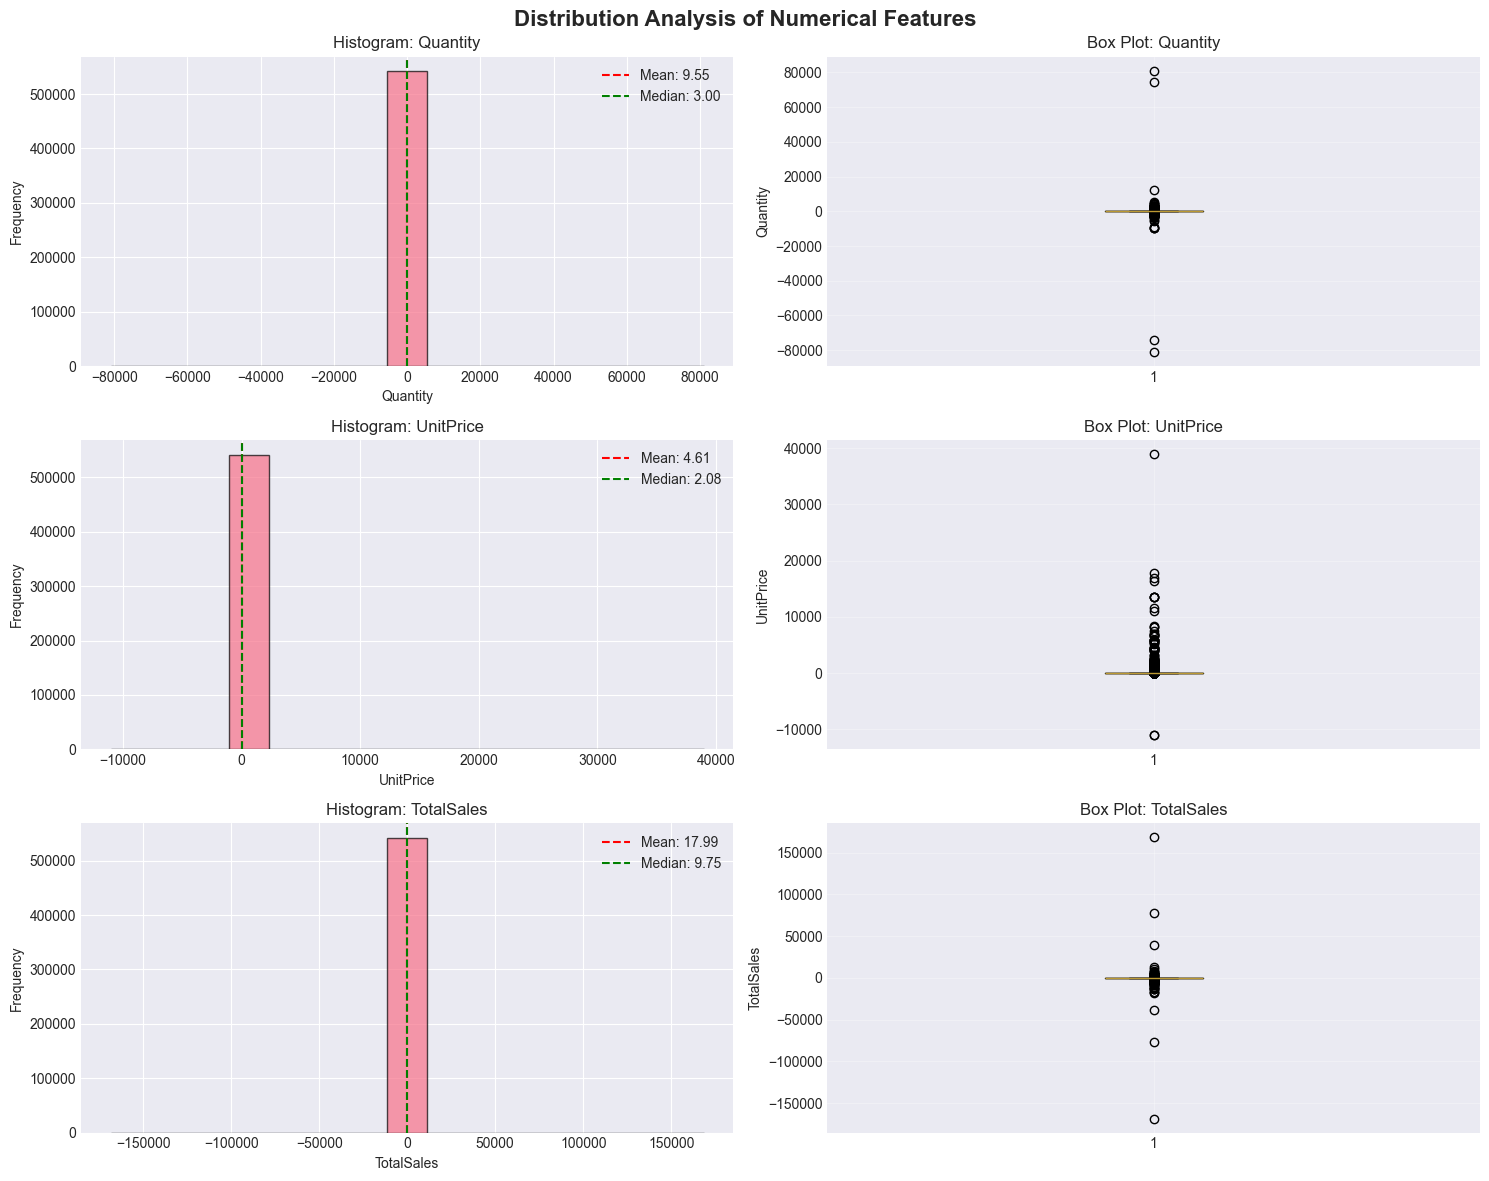

In [9]:
# Distribution Analysis
numerical_features = ['Quantity', 'UnitPrice', 'TotalSales']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Distribution Analysis of Numerical Features', fontsize=16, fontweight='bold')

for idx, col in enumerate(numerical_features):
    axes[idx, 0].hist(df[col], bins=15, edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'Histogram: {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
    axes[idx, 0].axvline(df[col].median(), color='green', linestyle='--', label=f'Median: {df[col].median():.2f}')
    axes[idx, 0].legend()
    
    axes[idx, 1].boxplot(df[col], vert=True)
    axes[idx, 1].set_title(f'Box Plot: {col}')
    axes[idx, 1].set_ylabel(col)
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


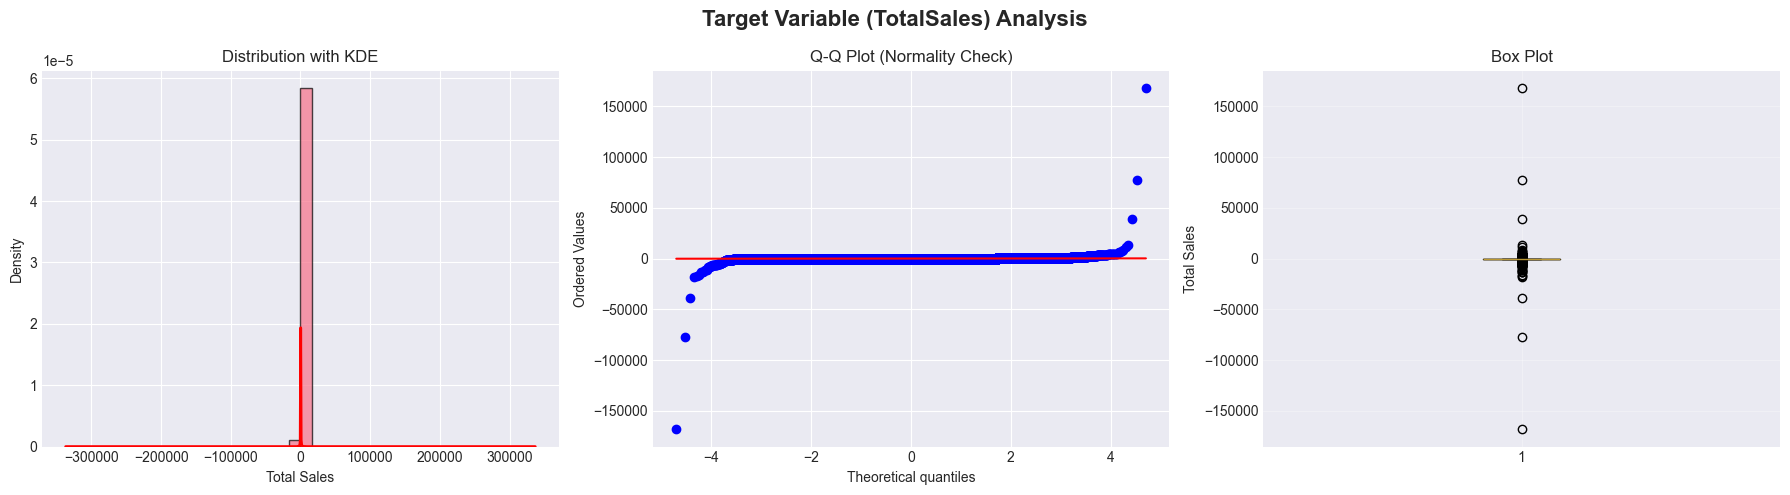


Normality Test (D'Agostino-Pearson):
  Test Statistic: 407227.2079
  P-value: 0.0000
  Target variable does not follow normal distribution (p < 0.05)


In [ ]:
# Target Variable Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Target Variable (TotalSales) Analysis', fontsize=16, fontweight='bold')

# Distribution with KDE (Kernel Density Estimation)
axes[0].hist(df['TotalSales'], bins=20, edgecolor='black', alpha=0.7, density=True)
df['TotalSales'].plot(kind='kde', ax=axes[0], color='red', linewidth=2)
axes[0].set_title('Distribution with KDE')
axes[0].set_xlabel('Total Sales')
axes[0].set_ylabel('Density')

# Q-Q Plot for normality check
stats.probplot(df['TotalSales'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)')

# Box plot
axes[2].boxplot(df['TotalSales'])
axes[2].set_title('Box Plot')
axes[2].set_ylabel('Total Sales')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Normality test
stat, p_value = normaltest(df['TotalSales'])
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"  Test Statistic: {stat:.4f}")
print(f"  P-value: {p_value:.4f}")
if p_value > 0.05:
    print("  Target variable appears to be normally distributed (p > 0.05)")
else:
    print("  Target variable does not follow normal distribution (p < 0.05)")

In [11]:
# Categorical Figure Analysis
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("="*80)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*80)

for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Top 5 values:")
    print(df[col].value_counts().head().to_string())

CATEGORICAL FEATURES ANALYSIS

InvoiceNo:
  Unique values: 25900
  Top 5 values:
InvoiceNo
573585    1114
581219     749
581492     731
580729     721
558475     705

StockCode:
  Unique values: 4070
  Top 5 values:
StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639

Description:
  Unique values: 4223
  Top 5 values:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638

InvoiceDate:
  Unique values: 23260
  Top 5 values:
InvoiceDate
10/31/2011 14:41    1114
12/8/2011 9:28       749
12/9/2011 10:03      731
12/5/2011 17:24      721
6/29/2011 15:58      705

Country:
  Unique values: 38
  Top 5 values:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533


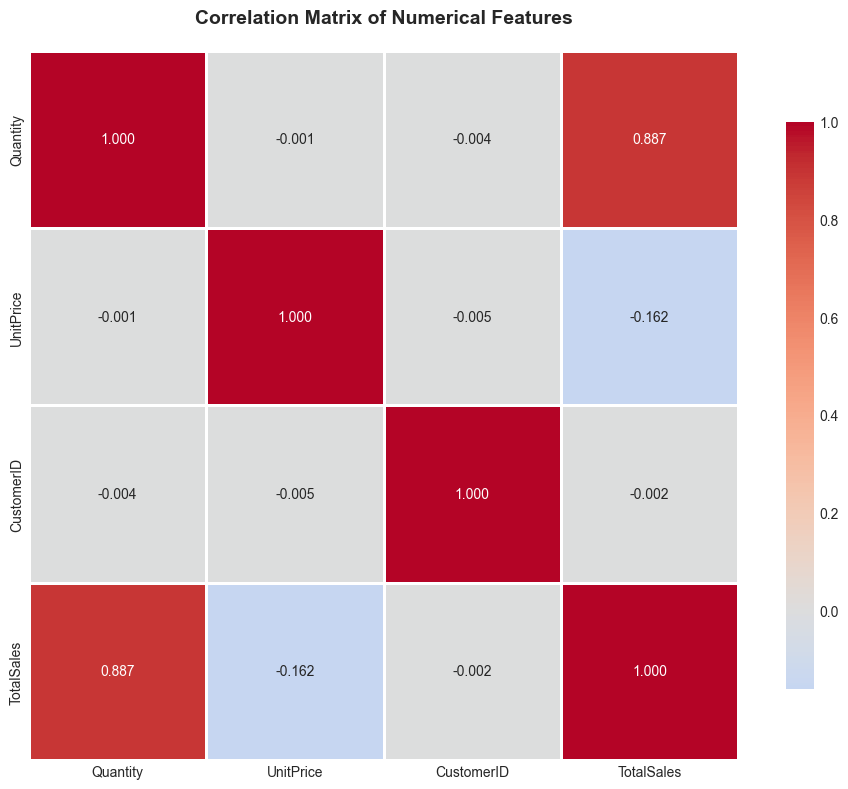


CORRELATIONS WITH TARGET VARIABLE (TotalSales)
TotalSales    1.000000
Quantity      0.886681
CustomerID   -0.002274
UnitPrice    -0.162029
Name: TotalSales, dtype: float64


In [12]:
# Correlation Analysis
numerical_df = df[numerical_cols]
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CORRELATIONS WITH TARGET VARIABLE (TotalSales)")
print("="*80)
target_corr = correlation_matrix['TotalSales'].sort_values(ascending=False)
print(target_corr)

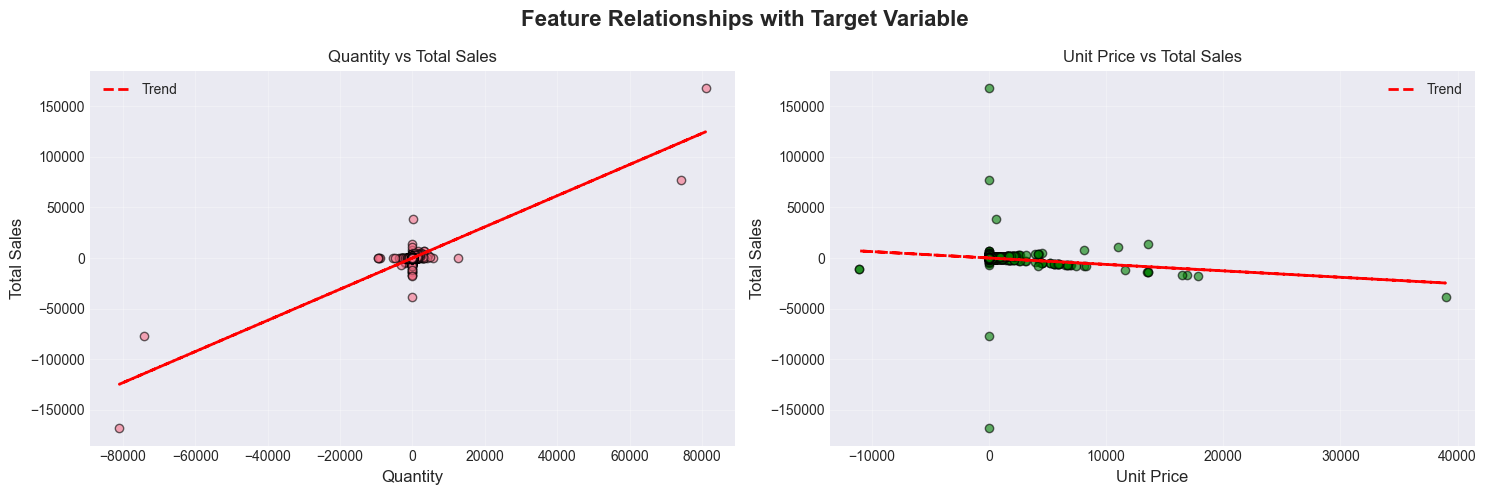

In [13]:
# Feature Relationships with Target
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Feature Relationships with Target Variable', fontsize=16, fontweight='bold')

axes[0].scatter(df['Quantity'], df['TotalSales'], alpha=0.6, edgecolor='black')
axes[0].set_xlabel('Quantity', fontsize=12)
axes[0].set_ylabel('Total Sales', fontsize=12)
axes[0].set_title('Quantity vs Total Sales')
axes[0].grid(True, alpha=0.3)

z = np.polyfit(df['Quantity'], df['TotalSales'], 1)
p = np.poly1d(z)
axes[0].plot(df['Quantity'], p(df['Quantity']), "r--", linewidth=2, label='Trend')
axes[0].legend()

axes[1].scatter(df['UnitPrice'], df['TotalSales'], alpha=0.6, edgecolor='black', color='green')
axes[1].set_xlabel('Unit Price', fontsize=12)
axes[1].set_ylabel('Total Sales', fontsize=12)
axes[1].set_title('Unit Price vs Total Sales')
axes[1].grid(True, alpha=0.3)

z = np.polyfit(df['UnitPrice'], df['TotalSales'], 1)
p = np.poly1d(z)
axes[1].plot(df['UnitPrice'], p(df['UnitPrice']), "r--", linewidth=2, label='Trend')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Outlier Detection (Multiple Methods)

Three complementary methods to detect outliers used:
1. **IQR Method** (Interquartile Range)
2. **Z-Score Method** (Standard deviations from mean)
3. **Isolation Forest** (ML-based anomaly detection)

In [14]:
from sklearn.ensemble import IsolationForest

print("="*80)
print("COMPREHENSIVE OUTLIER DETECTION")
print("="*80)

# Store outlier detection results
outlier_results = {}

# Method 1: IQR Method
print("\n" + "="*80)
print("METHOD 1: IQR (Interquartile Range) Method")
print("="*80)
print("Outlier definition: Values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]\n")

iqr_outliers = pd.DataFrame(index=df.index)

for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Mark outliers
    iqr_outliers[f'{col}_outlier'] = ((df[col] < lower_bound) | (df[col] > upper_bound))
    outlier_count = iqr_outliers[f'{col}_outlier'].sum()
    outlier_percentage = (outlier_count / len(df)) * 100
    
    print(f"{col}:")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Outliers: {outlier_count} ({outlier_percentage:.2f}%)")
    if outlier_count > 0:
        print(f"  Outlier values: {df[iqr_outliers[f'{col}_outlier']][col].tolist()}")
    print()

# Any row with at least one outlier
iqr_outlier_mask = iqr_outliers.any(axis=1)
print(f"Total rows with IQR outliers: {iqr_outlier_mask.sum()} ({iqr_outlier_mask.sum()/len(df)*100:.2f}%)")

COMPREHENSIVE OUTLIER DETECTION

METHOD 1: IQR (Interquartile Range) Method
Outlier definition: Values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]

Quantity:
  Lower Bound: -12.50
  Upper Bound: 23.50
  Outliers: 58619 (10.82%)
  Outlier values: [32, 24, 24, 24, 48, 24, 24, 24, 24, 24, 24, 24, 24, 24, 36, 80, 32, 48, 64, 120, 24, 24, 24, 48, 96, 24, 24, 24, 36, 50, 48, 40, 40, 36, 100, 100, 192, 192, 192, 432, 432, 24, 24, 48, 48, 144, 40, 288, 64, 100, 50, 96, 96, 48, 144, 40, 24, 24, 24, 48, 96, 100, -24, -24, -24, -24, 24, 24, 96, 96, 96, 96, 48, 32, 32, 24, 24, 24, 48, 48, 48, 24, 40, 40, 36, 96, 24, 36, 24, 24, 24, 24, 24, 24, 128, 24, 24, 24, 36, 25, 24, 30, 36, 28, 24, 24, 56, 72, 200, 72, 600, 48, 36, 48, 32, 48, 24, 24, 24, 24, 24, 24, 24, 24, 48, 24, 480, 48, 96, 144, 144, 72, 144, 36, 36, 36, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 80, 40, 50, 96, 24, 36, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 48, 48, 48, 48, 48, 48, 48, 48, 36, 24, 36, 24, 24, 24, 24, 24, 24, 

In [15]:
# Method 2: Z-Score Method
print("\n" + "="*80)
print("METHOD 2: Z-Score Method")
print("="*80)
print("Outlier definition: |Z-score| > 3 (more than 3 standard deviations from mean)\n")

zscore_outliers = pd.DataFrame(index=df.index)

for col in numerical_features:
    z_scores = np.abs(zscore(df[col]))
    zscore_outliers[f'{col}_outlier'] = z_scores > 3
    outlier_count = zscore_outliers[f'{col}_outlier'].sum()
    outlier_percentage = (outlier_count / len(df)) * 100
    
    print(f"{col}:")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Std Dev: {df[col].std():.2f}")
    print(f"  Outliers (|Z| > 3): {outlier_count} ({outlier_percentage:.2f}%)")
    if outlier_count > 0:
        outlier_values = df[zscore_outliers[f'{col}_outlier']][col].tolist()
        outlier_zscores = z_scores[zscore_outliers[f'{col}_outlier']].tolist()
        print(f"  Outlier values: {outlier_values}")
        print(f"  Z-scores: {[f'{z:.2f}' for z in outlier_zscores]}")
    print()

zscore_outlier_mask = zscore_outliers.any(axis=1)
print(f"Total rows with Z-score outliers: {zscore_outlier_mask.sum()} ({zscore_outlier_mask.sum()/len(df)*100:.2f}%)")


METHOD 2: Z-Score Method
Outlier definition: |Z-score| > 3 (more than 3 standard deviations from mean)

Quantity:
  Mean: 9.55
  Std Dev: 218.08
  Outliers (|Z| > 3): 346 (0.06%)
  Outlier values: [-9360, 1824, 2880, 1400, 1440, 720, 972, 972, 1008, 1008, 1000, 1488, 1394, -723, 1728, 2400, 752, 720, 960, 1296, -939, 720, -2600, -990, 860, 1010, 1356, 1284, 1000, 1930, 2000, 3114, 1300, 670, 74215, -74215, 720, 1440, -1400, 720, 720, 5568, 2560, 900, 960, 2592, 800, 1200, 864, -1430, 1287, 1296, 1296, 1296, 2400, 1056, 1500, 2400, -741, 3906, 1152, -720, 1200, 1152, 864, -3000, 864, -675, -975, -1200, -1121, -1277, 3000, -1100, -5368, 768, 720, 700, 900, 800, 1200, 720, 720, 1296, 2160, 1000, -2472, 1000, 720, 1440, -690, 864, 1200, 1152, 864, 1152, 864, 1200, -1479, -750, 1056, 1728, -1092, -670, -1300, -1930, -2000, -3114, 1300, 1930, 1300, 670, 2000, 3114, 960, 960, 720, 960, 960, 1008, 1200, 1200, 1152, -1512, 2000, -960, -2376, 1350, 1200, -1350, -786, 720, 864, -664, 720, 2700, 

In [ ]:
# Method 3: Isolation Forest (ML-based)
print("\n" + "="*80)
print("METHOD 3: Isolation Forest (Machine Learning-based)")
print("="*80)

X_outlier_detection = df[numerical_features].copy()

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_predictions = iso_forest.fit_predict(X_outlier_detection)

iso_outlier_mask = outlier_predictions == -1
outlier_count = iso_outlier_mask.sum()
outlier_percentage = (outlier_count / len(df)) * 100

print(f"Outliers detected: {outlier_count} ({outlier_percentage:.2f}%)")

if outlier_count > 0:
    print(f"\nOutlier rows (Isolation Forest):")
    print(df[iso_outlier_mask][numerical_features])


METHOD 3: Isolation Forest (Machine Learning-based)
Unsupervised anomaly detection algorithm

Outliers detected: 54082 (9.98%)

Outlier rows (Isolation Forest):
        Quantity  UnitPrice  TotalSales
9             32       1.69       54.08
26            24       3.75       90.00
27            24       3.75       90.00
31            48       0.85       40.80
34            24       2.95       70.80
...          ...        ...         ...
541866        36       1.85       66.60
541867        72       0.72       51.84
541868        48       1.85       88.80
541892        24       8.95      214.80
541893        10       7.08       70.80

[54082 rows x 3 columns]


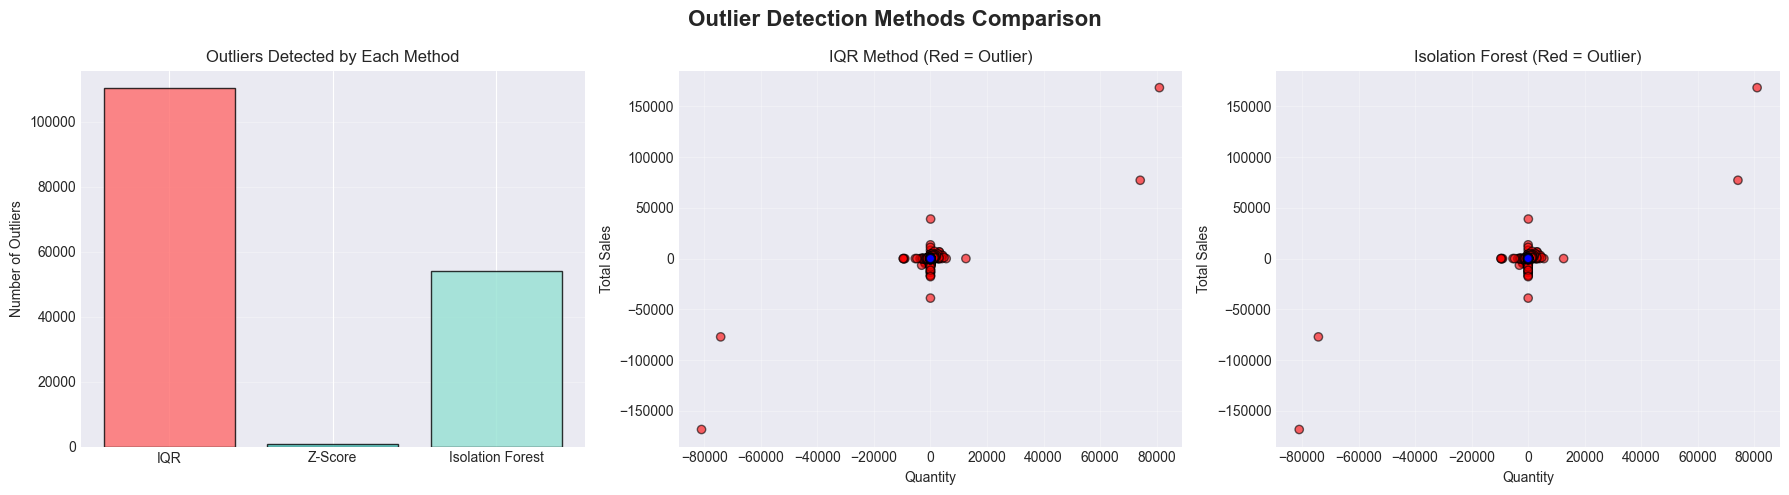

In [17]:
# Visualize outlier detection results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Outlier Detection Methods Comparison', fontsize=16, fontweight='bold')

methods = ['IQR', 'Z-Score', 'Isolation Forest']
counts = [iqr_outlier_mask.sum(), zscore_outlier_mask.sum(), iso_outlier_mask.sum()]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

# Bar chart of outlier counts
axes[0].bar(methods, counts, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('Number of Outliers')
axes[0].set_title('Outliers Detected by Each Method')
axes[0].grid(True, alpha=0.3, axis='y')

# Scatter plot: Quantity vs TotalSales (colored by IQR outliers)
colors_iqr = ['red' if x else 'blue' for x in iqr_outlier_mask]
axes[1].scatter(df['Quantity'], df['TotalSales'], c=colors_iqr, alpha=0.6, edgecolor='black')
axes[1].set_xlabel('Quantity')
axes[1].set_ylabel('Total Sales')
axes[1].set_title('IQR Method (Red = Outlier)')
axes[1].grid(True, alpha=0.3)

# Scatter plot: Quantity vs TotalSales (colored by Isolation Forest)
colors_iso = ['red' if x else 'blue' for x in iso_outlier_mask]
axes[2].scatter(df['Quantity'], df['TotalSales'], c=colors_iso, alpha=0.6, edgecolor='black')
axes[2].set_xlabel('Quantity')
axes[2].set_ylabel('Total Sales')
axes[2].set_title('Isolation Forest (Red = Outlier)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Consensus outliers which is detected by multiple methods
print("\n" + "="*80)
print("CONSENSUS OUTLIER ANALYSIS")
print("="*80)

# Create consensus dataframe
consensus_df = pd.DataFrame({
    'IQR': iqr_outlier_mask,
    'ZScore': zscore_outlier_mask,
    'IsolationForest': iso_outlier_mask
})

consensus_df['Methods_Count'] = consensus_df.sum(axis=1)

print("\nOutliers detected by number of methods:")
for i in range(4):
    count = (consensus_df['Methods_Count'] == i).sum()
    percentage = (count / len(df)) * 100
    print(f"  {i} methods: {count} rows ({percentage:.2f}%)")

# Rows detected as outliers by at least 2 methods
strong_outlier_mask = consensus_df['Methods_Count'] >= 2
print(f"\n Strong outliers (≥2 methods): {strong_outlier_mask.sum()} rows ({strong_outlier_mask.sum()/len(df)*100:.2f}%)")

if strong_outlier_mask.sum() > 0:
    print("\nStrong outlier details:")
    print(df[strong_outlier_mask][numerical_features])


CONSENSUS OUTLIER ANALYSIS

Outliers detected by number of methods:
  0 methods: 431054 rows (79.54%)
  1 methods: 57312 rows (10.58%)
  2 methods: 52631 rows (9.71%)
  3 methods: 912 rows (0.17%)

 Strong outliers (≥2 methods): 53543 rows (9.88%)

Strong outlier details:
        Quantity  UnitPrice  TotalSales
9             32       1.69       54.08
26            24       3.75       90.00
27            24       3.75       90.00
31            48       0.85       40.80
34            24       2.95       70.80
...          ...        ...         ...
541866        36       1.85       66.60
541867        72       0.72       51.84
541868        48       1.85       88.80
541892        24       8.95      214.80
541893        10       7.08       70.80

[53543 rows x 3 columns]


### Data Cleaning

In [19]:
# Check for missing values
print("Current missing values:")
print(df.isnull().sum())

if df.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    # By Median
    numerical_cols_with_missing = df.select_dtypes(include=[np.number]).columns[df.select_dtypes(include=[np.number]).isnull().any()]
    for col in numerical_cols_with_missing:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"  - {col}: filled with median")
    
    # By Mode
    categorical_cols_with_missing = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).isnull().any()]
    for col in categorical_cols_with_missing:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"  - {col}: filled with mode")
    
    print("\n Missing values handled!")
else:
    print("\n No missing values to handle!")

Current missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
TotalSales          0
dtype: int64

Handling missing values...
  - CustomerID: filled with median
  - Description: filled with mode

 Missing values handled!


In [20]:
# Remove duplicate rows if any
initial_rows = len(df)
df_cleaned = df.drop_duplicates()
final_rows = len(df_cleaned)
removed = initial_rows - final_rows

print(f"Initial rows: {initial_rows}")
print(f"Final rows: {final_rows}")
print(f"Duplicates removed: {removed}")

if removed > 0:
    print(f"{removed} duplicate rows removed successfully!")
else:
    print("No duplicates found!")

df = df_cleaned.copy()

Initial rows: 541909
Final rows: 536641
Duplicates removed: 5268
5268 duplicate rows removed successfully!


#### Handle Outliers

Since the dataset is large, these outlier handling strategy are used:

1. **Keep Outliers for Training** - To learn from all patterns
2. **Cap Extreme Outliers** - Using Winsorization at 1st and 99th percentiles
3. **Create Outlier Flag Feature** - For model to learn outlier patterns
4. **Use Robust Scaler** - Less sensitive to outliers than StandardScaler


In [21]:
df_before_outlier_handling = df.copy()

# 1: Winsorization (Capping) for extreme outliers
print("\n1. WINSORIZATION: Capping extreme values at 1st and 99th percentiles")
print("   (Preserves data while limiting extreme influence)\n")

winsorization_summary = []

for col in numerical_features:
    p1 = df[col].quantile(0.01)
    p99 = df[col].quantile(0.99)
    
    below_p1 = (df[col] < p1).sum()
    above_p99 = (df[col] > p99).sum()
    
    df[f'{col}_original'] = df[col]
    df[col] = df[col].clip(lower=p1, upper=p99)
    
    winsorization_summary.append({
        'Feature': col,
        'P1': f"{p1:.2f}",
        'P99': f"{p99:.2f}",
        'Capped_Low': below_p1,
        'Capped_High': above_p99,
        'Total_Capped': below_p1 + above_p99
    })
    
    print(f"{col}:")
    print(f"1st percentile: {p1:.2f}")
    print(f"99th percentile: {p99:.2f}")
    print(f"Values capped below: {below_p1}")
    print(f"Values capped above: {above_p99}")
    print(f"Total values modified: {below_p1 + above_p99}\n")

print("Winsorization Summary:")
print(pd.DataFrame(winsorization_summary).to_string(index=False))
print("\n Extreme outliers capped successfully!")


1. WINSORIZATION: Capping extreme values at 1st and 99th percentiles
   (Preserves data while limiting extreme influence)

Quantity:
1st percentile: -2.00
99th percentile: 100.00
Values capped below: 5032
Values capped above: 4948
Total values modified: 9980

UnitPrice:
1st percentile: 0.19
99th percentile: 18.00
Values capped below: 3624
Values capped above: 4789
Total values modified: 8413

TotalSales:
1st percentile: -6.62
99th percentile: 180.37
Values capped below: 5367
Values capped above: 5367
Total values modified: 10734

Winsorization Summary:
   Feature    P1    P99  Capped_Low  Capped_High  Total_Capped
  Quantity -2.00 100.00        5032         4948          9980
 UnitPrice  0.19  18.00        3624         4789          8413
TotalSales -6.62 180.37        5367         5367         10734

 Extreme outliers capped successfully!


In [22]:
# 2: Create Outlier Indicator Features

for col in numerical_features:
    Q1 = df[f'{col}_original'].quantile(0.25)
    Q3 = df[f'{col}_original'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[f'{col}_is_outlier'] = ((df[f'{col}_original'] < lower_bound) | 
                               (df[f'{col}_original'] > upper_bound)).astype(int)
    
    outlier_count = df[f'{col}_is_outlier'].sum()
    print(f"{col}_is_outlier: {outlier_count} flagged ({outlier_count/len(df)*100:.2f}%)")

outlier_cols = [f'{col}_is_outlier' for col in numerical_features]
df['outlier_score'] = df[outlier_cols].sum(axis=1)

print(f"\nComposite outlier score distribution:")
print(df['outlier_score'].value_counts().sort_index())
print("\n Outlier indicator features created!")

Quantity_is_outlier: 58501 flagged (10.90%)
UnitPrice_is_outlier: 39450 flagged (7.35%)
TotalSales_is_outlier: 45626 flagged (8.50%)

Composite outlier score distribution:
outlier_score
0    426492
1     77166
2     32538
3       445
Name: count, dtype: int64

 Outlier indicator features created!


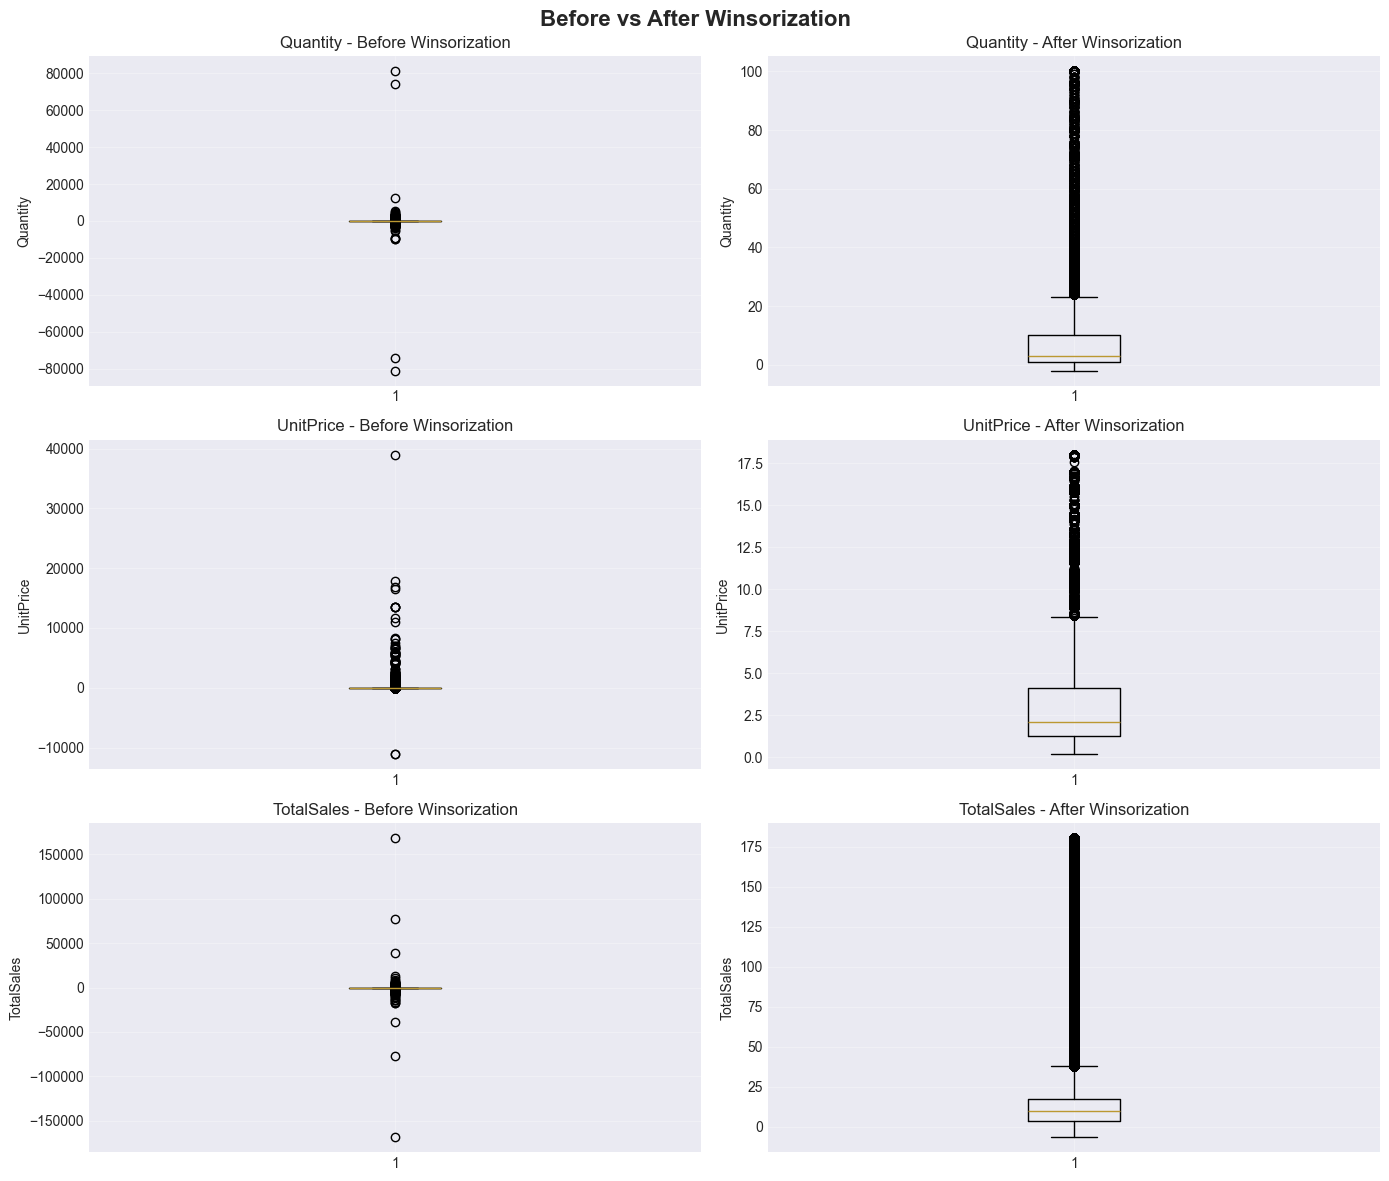

In [23]:
# Visualize before/after winsorization
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(14, 4*len(numerical_features)))
fig.suptitle('Before vs After Winsorization', fontsize=16, fontweight='bold')

for idx, col in enumerate(numerical_features):
    # Before
    axes[idx, 0].boxplot(df_before_outlier_handling[col], vert=True)
    axes[idx, 0].set_title(f'{col} - Before Winsorization')
    axes[idx, 0].set_ylabel(col)
    axes[idx, 0].grid(True, alpha=0.3)
    
    # After
    axes[idx, 1].boxplot(df[col], vert=True)
    axes[idx, 1].set_title(f'{col} - After Winsorization')
    axes[idx, 1].set_ylabel(col)
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [24]:
# Statistical comparison before/after

comparison_stats = []

for col in numerical_features:
    before = df_before_outlier_handling[col]
    after = df[col]
    
    comparison_stats.append({
        'Feature': col,
        'Mean_Before': f"{before.mean():.2f}",
        'Mean_After': f"{after.mean():.2f}",
        'Std_Before': f"{before.std():.2f}",
        'Std_After': f"{after.std():.2f}",
        'Skew_Before': f"{skew(before):.2f}",
        'Skew_After': f"{skew(after):.2f}",
        'Kurt_Before': f"{kurtosis(before):.2f}",
        'Kurt_After': f"{kurtosis(after):.2f}"
    })

comparison_df = pd.DataFrame(comparison_stats)
print(comparison_df.to_string(index=False))

   Feature Mean_Before Mean_After Std_Before Std_After Skew_Before Skew_After Kurt_Before Kurt_After
  Quantity        9.62       8.66     219.13     15.30       -0.26       4.08   118644.44      19.34
 UnitPrice        4.63       3.26      97.23      3.31      185.60       2.24    58432.59       5.68
TotalSales       18.12      16.48     380.66     26.78       -0.96       4.16   149741.46      19.96


### Feature Engineering

In [25]:
# Extract Temporal Features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Hour'] = df['InvoiceDate'].dt.hour
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)  # 1 if weekend, 0 otherwise

print("Temporal features created successfully!")
print("\nNew temporal features:")
print(df[['InvoiceDate', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour', 'IsWeekend']].head())

Temporal features created successfully!

New temporal features:
          InvoiceDate  Year  Month  Day  DayOfWeek  Hour  IsWeekend
0 2010-12-01 08:26:00  2010     12    1          2     8          0
1 2010-12-01 08:26:00  2010     12    1          2     8          0
2 2010-12-01 08:26:00  2010     12    1          2     8          0
3 2010-12-01 08:26:00  2010     12    1          2     8          0
4 2010-12-01 08:26:00  2010     12    1          2     8          0


In [26]:
# Create derived features
df['PriceCategory'] = pd.cut(df['UnitPrice'], 
                              bins=[0, 2, 4, 6, float('inf')],
                              labels=['Low', 'Medium', 'High', 'Premium'])

df['QuantityCategory'] = pd.cut(
                                df['Quantity'],
                                bins=[-float('inf'), 5, 10, float('inf')],
                                labels=['Small', 'Medium', 'Large'])

df['DescriptionLength'] = df['Description'].str.len()

print(df[['UnitPrice', 'PriceCategory', 'Quantity', 'QuantityCategory', 
          'DescriptionLength', 'outlier_score']].head())


   UnitPrice PriceCategory  Quantity QuantityCategory  DescriptionLength  \
0       2.55        Medium         6           Medium                 34   
1       3.39        Medium         6           Medium                 19   
2       2.75        Medium         8           Medium                 30   
3       3.39        Medium         6           Medium                 35   
4       3.39        Medium         6           Medium                 30   

   outlier_score  
0              0  
1              0  
2              0  
3              0  
4              0  


In [27]:
# Encode data for modelling
df_model = df.copy()

country_encoded = pd.get_dummies(df_model['Country'], prefix='Country', drop_first=True)

price_cat_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Premium': 3}
quantity_cat_mapping = {'Small': 0, 'Medium': 1, 'Large': 2}

df_model['PriceCategory_Encoded'] = df_model['PriceCategory'].map(price_cat_mapping)
df_model['QuantityCategory_Encoded'] = df_model['QuantityCategory'].map(quantity_cat_mapping)

df_model = pd.concat([df_model, country_encoded], axis=1)

print(f"\nEncoded features shape: {df_model.shape}")
print(f"New encoded columns: {len(country_encoded.columns)} country dummy variables")


Encoded features shape: (536641, 64)
New encoded columns: 37 country dummy variables


In [31]:
# Feature Selection

feature_columns = ['CustomerID', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour', 
                   'IsWeekend', 'DescriptionLength', 'PriceCategory_Encoded', 
                   'QuantityCategory_Encoded', 'outlier_score'] + \
                  [f'{col}_is_outlier' for col in numerical_features] + \
                  list(country_encoded.columns)

X = df_model[feature_columns]
y = df_model['TotalSales']


print(f"\nNumber of features selected: {len(feature_columns)}")
print(f"\nSelected features:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

print(f"\nTarget variable: TotalSales (after winsorization)")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

print("\n" + "="*80)
print("OUTLIER-RELATED FEATURES INCLUDED:")
print("="*80)
outlier_features = [col for col in feature_columns if 'outlier' in col.lower()]
for feat in outlier_features:
    print(f" {feat}")


Number of features selected: 51

Selected features:
  1. CustomerID
  2. Year
  3. Month
  4. Day
  5. DayOfWeek
  6. Hour
  7. IsWeekend
  8. DescriptionLength
  9. PriceCategory_Encoded
  10. QuantityCategory_Encoded
  11. outlier_score
  12. Quantity_is_outlier
  13. UnitPrice_is_outlier
  14. TotalSales_is_outlier
  15. Country_Austria
  16. Country_Bahrain
  17. Country_Belgium
  18. Country_Brazil
  19. Country_Canada
  20. Country_Channel Islands
  21. Country_Cyprus
  22. Country_Czech Republic
  23. Country_Denmark
  24. Country_EIRE
  25. Country_European Community
  26. Country_Finland
  27. Country_France
  28. Country_Germany
  29. Country_Greece
  30. Country_Hong Kong
  31. Country_Iceland
  32. Country_Israel
  33. Country_Italy
  34. Country_Japan
  35. Country_Lebanon
  36. Country_Lithuania
  37. Country_Malta
  38. Country_Netherlands
  39. Country_Norway
  40. Country_Poland
  41. Country_Portugal
  42. Country_RSA
  43. Country_Saudi Arabia
  44. Country_Singapor

### Data Splitting

- **Training set (70%):** For model training
- **Validation set (15%):** For hyperparameter tuning
- **Test set (15%):** For final model evaluation

In [32]:
# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Second split: separate training (70%) and validation (15%) from temp (85%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42
)

print(f"\nTotal samples: {len(X)}")
print(f"\nTraining set:   {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:       {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nFeature dimensions: {X_train.shape[1]} (including {len(outlier_features)} outlier features)")
print(f"\nTarget variable statistics:")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


Total samples: 536641

Training set:   375862 samples (70.0%)
Validation set: 80282 samples (15.0%)
Test set:       80497 samples (15.0%)

Feature dimensions: 51 (including 4 outlier features)

Target variable statistics:
  Train - Mean: 16.48, Std: 26.80
  Val   - Mean: 16.57, Std: 26.98
  Test  - Mean: 16.36, Std: 26.51


In [33]:
# Feature Scaling Using RobustScaler
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nScaling Statistics (Training Set):")
print(f"  Median: {X_train_scaled.median().mean():.6f}")
print(f"  IQR:    {(X_train_scaled.quantile(0.75) - X_train_scaled.quantile(0.25)).mean():.6f}")
print("\nFirst 3 rows of scaled training data:")
print(X_train_scaled.head(3))


Scaling Statistics (Training Set):
  Median: 0.000000
  IQR:    0.156863

First 3 rows of scaled training data:
        CustomerID  Year     Month       Day  DayOfWeek  Hour  IsWeekend  \
411660   -0.053695   0.0  0.333333  0.400000   0.666667  0.25        0.0   
518145    0.000000   0.0  0.666667 -0.933333   0.333333  0.75        0.0   
145391    0.000000   0.0 -0.666667 -0.733333  -0.666667  0.50        0.0   

        DescriptionLength  PriceCategory_Encoded  QuantityCategory_Encoded  \
411660             -0.375                    1.0                       0.0   
518145             -0.500                   -0.5                       0.0   
145391             -0.375                    1.0                       0.0   

        ...  Country_RSA  Country_Saudi Arabia  Country_Singapore  \
411660  ...          0.0                   0.0                0.0   
518145  ...          0.0                   0.0                0.0   
145391  ...          0.0                   0.0                

### Model Development and Training

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    y_train_pred = model.predict(X_train)
    
    y_val_pred = model.predict(X_val)
    
    metrics = {
        'Model': model_name,
        'Train_R2': r2_score(y_train, y_train_pred),
        'Val_R2': r2_score(y_val, y_val_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Val_RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)), # Root Mean Square Error
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Val_MAE': mean_absolute_error(y_val, y_val_pred)
    }
    
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    metrics['Train_MAPE'] = mape(y_train, y_train_pred) # Mean Absolute Percentage Error
    metrics['Val_MAPE'] = mape(y_val, y_val_pred)
    
    return metrics

In [35]:
# Train baseline models

models = {}
results = []

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
models['Linear Regression'] = lr
lr_metrics = evaluate_model(lr, X_train_scaled, y_train, X_val_scaled, y_val, 'Linear Regression')
results.append(lr_metrics)
print(f"   Completed - Val R²: {lr_metrics['Val_R2']:.4f}")

# 2. Ridge Regression
print("\n2. Training Ridge Regression...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
models['Ridge Regression'] = ridge
ridge_metrics = evaluate_model(ridge, X_train_scaled, y_train, X_val_scaled, y_val, 'Ridge Regression')
results.append(ridge_metrics)
print(f"   Completed - Val R²: {ridge_metrics['Val_R2']:.4f}")

# 3. Random Forest Regressor
print("\n3. Training Random Forest Regressor...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5, min_samples_split=2)
rf.fit(X_train, y_train) 
models['Random Forest'] = rf
rf_metrics = evaluate_model(rf, X_train, y_train, X_val, y_val, 'Random Forest')
results.append(rf_metrics)
print(f"   Completed - Val R²: {rf_metrics['Val_R2']:.4f}")

# 4. Gradient Boosting Regressor
print("\n4. Training Gradient Boosting Regressor...")
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
models['Gradient Boosting'] = gb
gb_metrics = evaluate_model(gb, X_train, y_train, X_val, y_val, 'Gradient Boosting')
results.append(gb_metrics)
print(f"   Completed - Val R²: {gb_metrics['Val_R2']:.4f}")



1. Training Linear Regression...
   Completed - Val R²: 0.6715

2. Training Ridge Regression...
   Completed - Val R²: 0.6715

3. Training Random Forest Regressor...
   Completed - Val R²: 0.7788

4. Training Gradient Boosting Regressor...
   Completed - Val R²: 0.7952


#### Compare Model Performance

In [36]:
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

best_model_idx = results_df['Val_R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'Val_R2']

print("\n" + "="*80)
print(f" BEST PERFORMING MODEL: {best_model_name}")
print(f"   Validation R² Score: {best_r2:.4f}")
print("="*80)

MODEL COMPARISON SUMMARY
            Model  Train_R2  Val_R2  Train_RMSE  Val_RMSE  Train_MAE  Val_MAE  Train_MAPE  Val_MAPE
Linear Regression    0.6662  0.6715     15.4816   15.4639     7.8056   7.7818         inf       inf
 Ridge Regression    0.6662  0.6715     15.4817   15.4632     7.8047   7.7806         inf       inf
    Random Forest    0.7768  0.7788     12.6588   12.6888     6.1555   6.1582         inf       inf
Gradient Boosting    0.7934  0.7952     12.1809   12.2093     6.0392   6.0337         inf       inf

 BEST PERFORMING MODEL: Gradient Boosting
   Validation R² Score: 0.7952


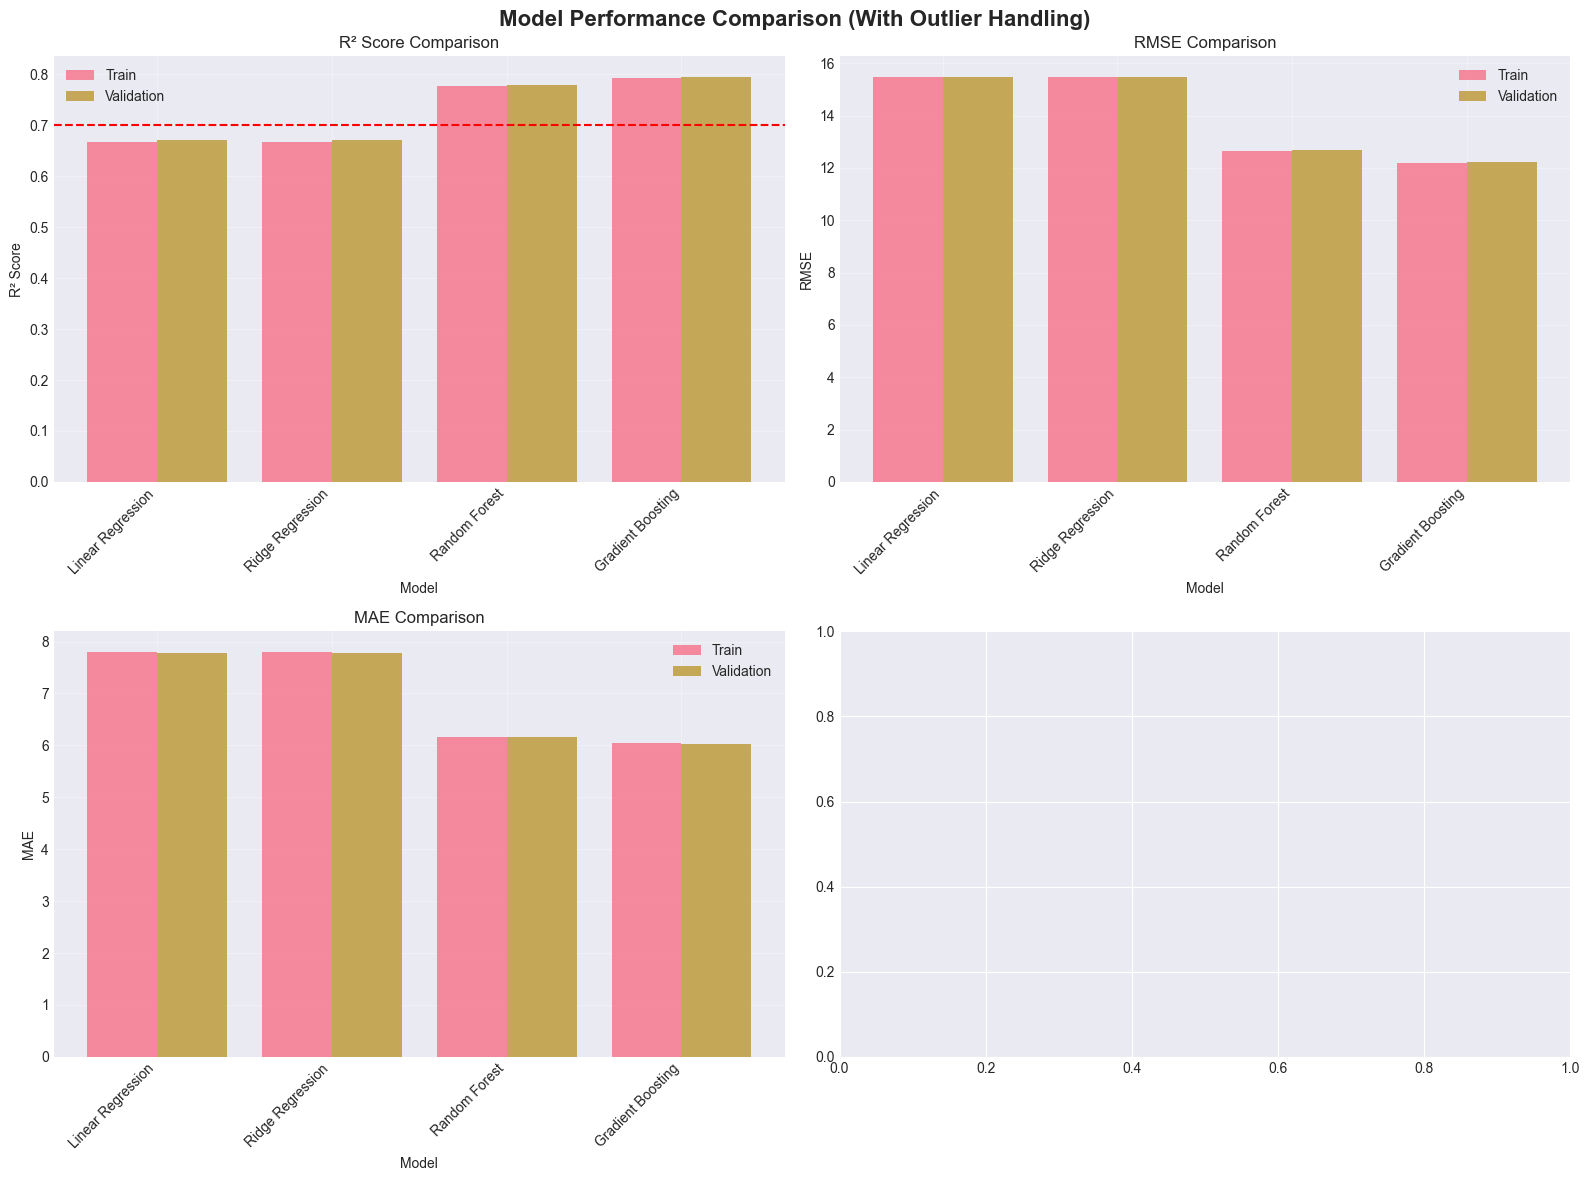

In [38]:
# Visualizating Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison (With Outlier Handling)', fontsize=16, fontweight='bold')

x_pos = np.arange(len(results_df))

# R² Score
axes[0, 0].bar(x_pos - 0.2, results_df['Train_R2'], width=0.4, label='Train', alpha=0.8)
axes[0, 0].bar(x_pos + 0.2, results_df['Val_R2'], width=0.4, label='Validation', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0.7, color='r', linestyle='--', label='Target (0.70)')

# RMSE
axes[0, 1].bar(x_pos - 0.2, results_df['Train_RMSE'], width=0.4, label='Train', alpha=0.8)
axes[0, 1].bar(x_pos + 0.2, results_df['Val_RMSE'], width=0.4, label='Validation', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MAE
axes[1, 0].bar(x_pos - 0.2, results_df['Train_MAE'], width=0.4, label='Train', alpha=0.8)
axes[1, 0].bar(x_pos + 0.2, results_df['Val_MAE'], width=0.4, label='Validation', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('MAE Comparison')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
# Select the best performing model
selected_model = models[best_model_name]

print(f"SELECTED MODEL FOR HYPERPARAMETER TUNING: {best_model_name}")
print("="*80)
print(f"\nCurrent Performance:")
print(f"  Validation R²: {best_r2:.4f}")


SELECTED MODEL FOR HYPERPARAMETER TUNING: Gradient Boosting

Current Performance:
  Validation R²: 0.7952


In [61]:
# Define hyperparameter grids
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    base_model = RandomForestRegressor(random_state=42)
    use_scaled = False
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = GradientBoostingRegressor(random_state=42)
    use_scaled = False
    
elif best_model_name == 'Ridge Regression':
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
    }
    base_model = Ridge(random_state=42)
    use_scaled = True

else: 
    param_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False]
    }
    base_model = LinearRegression()
    use_scaled = True

print(f"Hyperparameter grid defined for {best_model_name}:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations to test: {np.prod([len(v) for v in param_grid.values()])}")

Hyperparameter grid defined for Gradient Boosting:
  n_estimators: [50, 100, 200]
  learning_rate: [0.01, 0.05, 0.1, 0.2]
  max_depth: [3, 5, 7]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  subsample: [0.8, 0.9, 1.0]

Total combinations to test: 972


In [44]:
# Performing Randomized Search

X_train_cv = X_train_scaled if use_scaled else X_train
X_val_cv = X_val_scaled if use_scaled else X_val

randomized_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=20,                       
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

randomized_search.fit(X_train_cv, y_train)

print("BEST HYPERPARAMETERS")
print("="*80)
for param, value in randomized_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation R² Score: {randomized_search.best_score_:.4f}")

PERFORMING RANDOMIZED SEARCH
Fitting 3 folds for each of 20 candidates, totalling 60 fits


BEST HYPERPARAMETERS
  subsample: 0.9
  n_estimators: 100
  min_samples_split: 10
  min_samples_leaf: 4
  max_depth: 7
  learning_rate: 0.2

Best Cross-Validation R² Score: 0.8365


In [64]:
# EVALUATE TUNED MODEL FROM RANDOMIZED SEARCH

print("EVALUATING TUNED MODEL")
print("="*80)

best_tuned_model = randomized_search.best_estimator_

print(f"\n Best CV R² Score: {randomized_search.best_score_:.4f}")
print(f"\nBest Hyperparameters:")
for param, value in randomized_search.best_params_.items():
    print(f"  {param}: {value}")

tuned_metrics = evaluate_model(
    best_tuned_model, X_train_cv, y_train, X_val_cv, y_val, 
    f'{best_model_name} (Tuned)'
)

print("\n" + "="*80)
print("BEFORE vs AFTER TUNING")
print("="*80)

original_metrics = results_df[results_df['Model'] == best_model_name].iloc[0].to_dict()
comparison = pd.DataFrame([original_metrics, tuned_metrics])
comparison['Model'] = [f'{best_model_name} (Original)', f'{best_model_name} (Tuned)']

cols = comparison.columns.tolist()
cols.remove('Model')
comparison = comparison[['Model'] + cols]

print(comparison.to_string(index=False))

print("IMPROVEMENT METRICS")
print("="*80)

original_r2 = original_metrics['Val_R2']
tuned_r2 = tuned_metrics['Val_R2']
improvement_r2 = ((tuned_r2 - original_r2) / abs(original_r2)) * 100

original_rmse = original_metrics['Val_RMSE']
tuned_rmse = tuned_metrics['Val_RMSE']
improvement_rmse = ((original_rmse - tuned_rmse) / original_rmse) * 100

original_mae = original_metrics['Val_MAE']
tuned_mae = tuned_metrics['Val_MAE']
improvement_mae = ((original_mae - tuned_mae) / original_mae) * 100

original_mape = original_metrics['Val_MAPE']
tuned_mape = tuned_metrics['Val_MAPE']
improvement_mape = ((original_mape - tuned_mape) / original_mape) * 100

print(f"\nR² Score Improvement:    {improvement_r2:+.2f}%")
print(f"RMSE Improvement:        {improvement_rmse:+.2f}%")
print(f"MAE Improvement:         {improvement_mae:+.2f}%")

print("\n" + "="*80)
print("OVERFITTING ANALYSIS")
print("="*80)

overfit_original = abs(original_metrics['Train_R2'] - original_metrics['Val_R2'])
overfit_tuned = abs(tuned_metrics['Train_R2'] - tuned_metrics['Val_R2'])

print(f"\nOriginal Model Train/Val Gap: {overfit_original:.4f}")
print(f"Tuned Model Train/Val Gap:    {overfit_tuned:.4f}")

if overfit_tuned < overfit_original:
    print(f"Tuning REDUCED overfitting by {(overfit_original - overfit_tuned):.4f}")
else:
    print(f"uning increased overfitting slightly")

# Final recommendation
print("RECOMMENDATION")
print("="*80)

if tuned_r2 > original_r2:
    print(f"USE TUNED MODEL (R² improved: {original_r2:.4f} → {tuned_r2:.4f})")
else:
    print(f"⚠ ORIGINAL MODEL IS BETTER (R²: {original_r2:.4f} > {tuned_r2:.4f})")


EVALUATING TUNED MODEL

 Best CV R² Score: 0.8365

Best Hyperparameters:
  subsample: 0.9
  n_estimators: 100
  min_samples_split: 10
  min_samples_leaf: 4
  max_depth: 7
  learning_rate: 0.2

BEFORE vs AFTER TUNING
                       Model  Train_R2   Val_R2  Train_RMSE  Val_RMSE  Train_MAE  Val_MAE  Train_MAPE  Val_MAPE
Gradient Boosting (Original)  0.793400 0.795200   12.180900 12.209300   6.039200 6.033700         inf       inf
   Gradient Boosting (Tuned)  0.861386 0.840988    9.976921 10.758584   5.116768 5.308535         inf       inf
IMPROVEMENT METRICS

R² Score Improvement:    +5.76%
RMSE Improvement:        +11.88%
MAE Improvement:         +12.02%

OVERFITTING ANALYSIS

Original Model Train/Val Gap: 0.0018
Tuned Model Train/Val Gap:    0.0204
uning increased overfitting slightly
RECOMMENDATION
USE TUNED MODEL (R² improved: 0.7952 → 0.8410)


FEATURE IMPORTANCE ANALYSIS
                     Feature   Importance
       TotalSales_is_outlier 6.684512e-01
    QuantityCategory_Encoded 9.439887e-02
       PriceCategory_Encoded 7.612921e-02
         Quantity_is_outlier 5.118187e-02
                  CustomerID 4.093289e-02
           DescriptionLength 2.953946e-02
               outlier_score 1.121787e-02
                         Day 4.857182e-03
                        Hour 4.472236e-03
         Country_Netherlands 4.415338e-03
                       Month 4.010805e-03
                   DayOfWeek 2.499444e-03
      Country_United Kingdom 2.235700e-03
        UnitPrice_is_outlier 2.060489e-03
                Country_EIRE 6.069709e-04
                        Year 3.806294e-04
                   IsWeekend 3.027983e-04
              Country_Sweden 2.723623e-04
               Country_Spain 2.694974e-04
            Country_Portugal 2.401143e-04
             Country_Finland 1.799842e-04
              Country_France 1.584843e-04
      

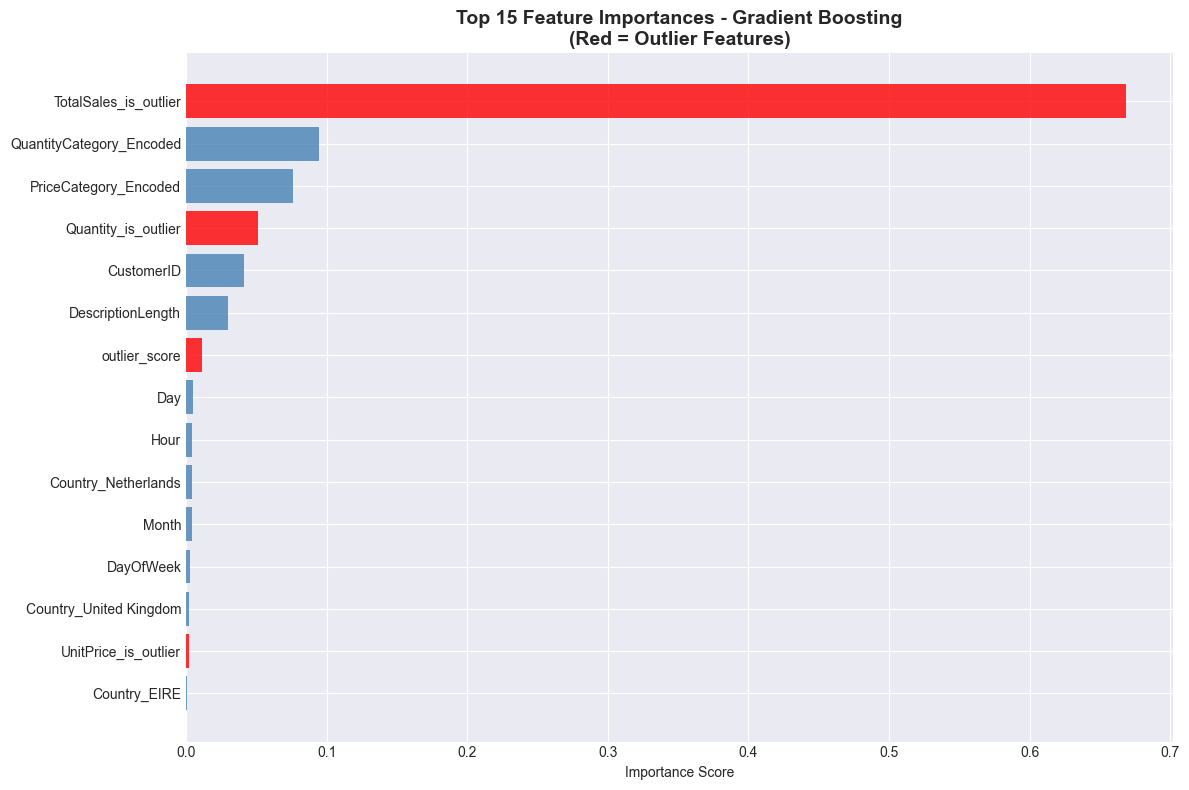

In [50]:
# Feature importance analysis
if hasattr(best_tuned_model, 'feature_importances_'):
    importances = best_tuned_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    print(feature_importance_df.to_string(index=False))
    
    # Highlight outlier-related features
    outlier_features_importance = feature_importance_df[feature_importance_df['Feature'].str.contains('outlier')]
    if len(outlier_features_importance) > 0:
        print("\n" + "="*80)
        print("OUTLIER-RELATED FEATURE IMPORTANCE")
        print("="*80)
        print(outlier_features_importance.to_string(index=False))
        print(f"\nTotal importance from outlier features: {outlier_features_importance['Importance'].sum():.4f}")
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    colors = ['red' if 'outlier' in feat else 'steelblue' for feat in top_features['Feature']]
    plt.barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Top 15 Feature Importances - {best_model_name}\n(Red = Outlier Features)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\nFeature importance not available for this model type.")

### Model Testing

In [53]:
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*80)

X_test_eval = X_test_scaled if use_scaled else X_test

y_test_pred = best_tuned_model.predict(X_test_eval)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"\nTest Set Performance:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE:     {test_rmse:.4f}")
print(f"  MAE:      {test_mae:.4f}")

print("SUCCESS CRITERIA EVALUATION")
print("="*80)
print(f"\nR² Score ≥ 0.70: {'PASS' if test_r2 >= 0.70 else 'FAIL'} ({test_r2:.4f})")

FINAL MODEL EVALUATION ON TEST SET

Test Set Performance:
  R² Score: 0.8396
  RMSE:     10.6146
  MAE:      5.2553
SUCCESS CRITERIA EVALUATION

R² Score ≥ 0.70: PASS (0.8396)


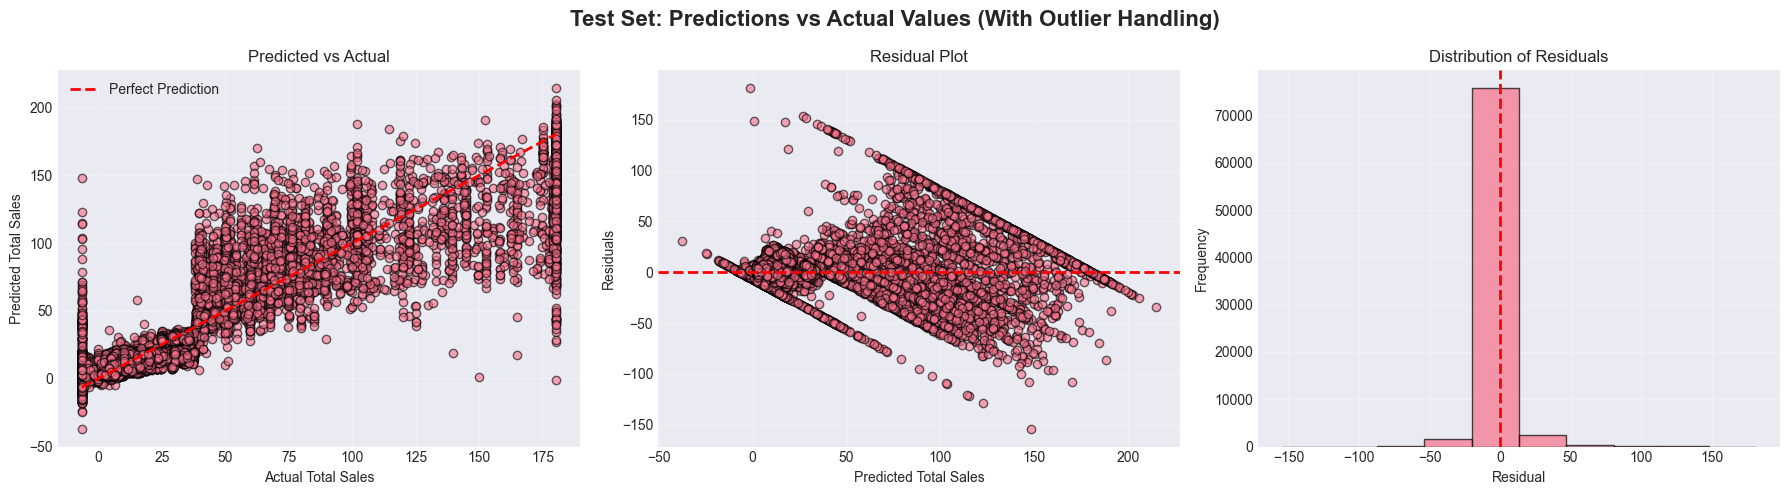


Residual Statistics:
  Mean:     0.0137
  Std Dev:  10.6146
  Min:      -154.7434
  Max:      181.6771


In [54]:
# Visualize predition vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Test Set: Predictions vs Actual Values (With Outlier Handling)', fontsize=16, fontweight='bold')

# Scatter plot
axes[0].scatter(y_test, y_test_pred, alpha=0.6, edgecolor='black')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Total Sales')
axes[0].set_ylabel('Predicted Total Sales')
axes[0].set_title('Predicted vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.6, edgecolor='black')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Total Sales')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

# Distribution of residuals
axes[2].hist(residuals, bins=10, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Residual')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Residuals')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual Statistics:")
print(f"  Mean:     {residuals.mean():.4f}")
print(f"  Std Dev:  {residuals.std():.4f}")
print(f"  Min:      {residuals.min():.4f}")
print(f"  Max:      {residuals.max():.4f}")

### Sample Prediction

In [56]:
# Show sample predictions
sample_predictions = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Error': residuals.values,
    'Error_%': (np.abs(residuals.values) / y_test.values * 100)
})

print("="*80)
print("SAMPLE PREDICTIONS FROM TEST SET")
print("="*80)
print(sample_predictions.round(2).to_string())

within_20_percent = (sample_predictions['Error_%'] <= 20).sum()
accuracy_rate = (within_20_percent / len(sample_predictions)) * 100

print(f"\nPredictions within ±20% error: {within_20_percent}/{len(sample_predictions)} ({accuracy_rate:.1f}%)")

SAMPLE PREDICTIONS FROM TEST SET
       Actual  Predicted   Error    Error_%
0        5.79       7.92   -2.13      36.74
1        1.63       1.82   -0.19      11.75
2       20.85      15.07    5.78      27.73
3       15.00      12.63    2.37      15.82
4        3.26       1.65    1.61      49.40
5       19.80      15.76    4.04      20.43
6        2.10       6.32   -4.22     200.91
7       10.40      14.25   -3.85      37.04
8       15.30      19.39   -4.09      26.74
9       15.90      15.47    0.43       2.72
10      19.90      18.23    1.67       8.39
11       1.63       2.33   -0.70      43.03
12      10.00      12.89   -2.89      28.90
13      33.00      18.17   14.83      44.93
14      50.40      85.20  -34.80      69.05
15       5.00       2.13    2.87      57.35
16      17.00      16.52    0.48       2.85
17       3.90       1.82    2.08      53.34
18      17.22      18.83   -1.61       9.34
19      45.43      70.15  -24.72      54.41
20      17.70      19.51   -1.81      10.22

### Model Metadata

In [58]:
# Create comprehensive model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': 'Regression',
    'target_variable': 'TotalSales',
    'features': list(X_train.columns),
    'num_features': len(X_train.columns),
    'requires_scaling': use_scaled,
    'scaler_type': 'RobustScaler',
    'outlier_handling': {
        'method': 'Winsorization',
        'percentiles': '1st-99th',
        'outlier_features_included': True,
        'outlier_detection_methods': ['IQR', 'Z-Score', 'Isolation Forest']
    },
    'best_hyperparameters': randomized_search.best_params_,
    'performance_metrics': {
        'train_r2': float(tuned_metrics['Train_R2']),
        'val_r2': float(tuned_metrics['Val_R2']),
        'test_r2': float(test_r2),
        'test_rmse': float(test_rmse),
        'test_mae': float(test_mae),
        'test_mape': float(test_mape)
    },
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'total_samples': len(df),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test)
    }
}

# Save metadata
import json
metadata_filename = 'model_metadata_with_outlier_handling.json'
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=4)

print("✓ Model metadata saved successfully!")
print(f"\nMetadata file: {metadata_filename}")
print("\nKey metadata highlights:")
print(f"  - Model: {best_model_name}")
print(f"  - Scaler: RobustScaler (outlier-resistant)")
print(f"  - Outlier handling: Winsorization (1st-99th percentile)")
print(f"  - Test R²: {test_r2:.4f}")
print(f"  - Features: {len(X_train.columns)} (including outlier indicators)")

✓ Model metadata saved successfully!

Metadata file: model_metadata_with_outlier_handling.json

Key metadata highlights:
  - Model: Gradient Boosting
  - Scaler: RobustScaler (outlier-resistant)
  - Outlier handling: Winsorization (1st-99th percentile)
  - Test R²: 0.8396
  - Features: 51 (including outlier indicators)


In [60]:
import os
os.makedirs('models', exist_ok=True)

model_filename = f'models/retail_demand_prediction_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(selected_model, model_filename)

scaler_filename = 'models/retail_demand_prediction_feature_scaler.pkl'
joblib.dump(scaler, scaler_filename)


['models/retail_demand_prediction_feature_scaler.pkl']